In [1]:
import numpy as np
import thinkstats2
import thinkplot
import pandas
import math
import nsfg

In [2]:
# 准备数据
preg = nsfg.ReadFemPreg(dct_file='datasets/2002FemPreg.dct',  dat_file='datasets/2002FemPreg.dat.gz')

full_term = preg[preg.prglngth >= 37]
weights = preg.totalwgt_lb.dropna()
term_weights = full_term.totalwgt_lb.dropna()

# 05. 分布建模
目前为止，我们使用的分布都是基于有限样本的经验观察，因此称为`经验分布`（empirical distribution）。

在经验分布之外还有`分析分布`（analytic distribution）。分析分布的CDF是一个数学函数。分析分布可以用作经验分布的建模。此处所说的模型（model）是一种简化，以去除不必要的细节。本章将介绍常用的分析分布，以及如何使用这些分析分布对各种数据建模。

本章代码位于`analytic.py`中。

## 5.1 指数分布
`指数分布`（exponential distribution）相对简单。指数分布的CDF为：
+ $\rm CDF(x) = 1-e^{-\lambda x}$

参数$\lambda$决定了分布的形状。下图展示了当$\lambda = 0.5、1、2$时CDF的形状：

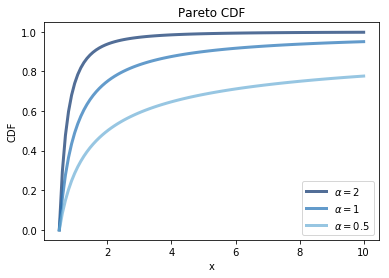

<Figure size 576x432 with 0 Axes>

In [3]:
def MakeParetoCdf():
    """Generates a plot of the Pareto CDF."""
    xmin = 0.5

    thinkplot.PrePlot(3)
    for alpha in [2.0, 1.0, 0.5]:
        xs, ps = thinkstats2.RenderParetoCdf(xmin, alpha, 0, 10.0, n=100) 
        thinkplot.Plot(xs, ps, label=r'$\alpha=%g$' % alpha)
    
    thinkplot.Show(root='analytic_pareto_cdf',
                   title='Pareto CDF',
                   xlabel='x',
                   ylabel='CDF')

thinkstats2.RandomSeed(18)
MakeParetoCdf()

在现实世界中，如果我们观察一系列事件，对事件发生的时间间隔，即`到达间隔`（interarrival time）进行测量，可能会得到指数分布。如果事件在任意时间发生的可能性相同，到达间隔的分布就会近似一个指数分布。

举例说明，让我们来看看婴儿出生的到达间隔。1997年12月18日，澳大利亚布里斯班的一家医院有44个婴儿出生，`ThinkStats2`代码库中的`babyboom.dat`文件包含了这44个婴儿出生时间的完整数据：

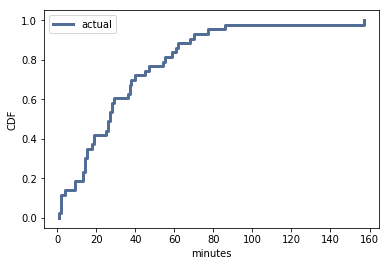

<Figure size 576x432 with 0 Axes>

In [4]:
def ReadBabyBoom(filename='babyboom.dat'):
    var_info = [
        ('time', 1, 8, int),
        ('sex', 9, 16, int),
        ('weight_g', 17, 24, int),
        ('minutes', 25, 32, int),
        ]
    columns = ['name', 'start', 'end', 'type']
    variables = pandas.DataFrame(var_info, columns=columns)
    variables.end += 1
    dct = thinkstats2.FixedWidthVariables(variables, index_base=1)

    df = dct.ReadFixedWidth(filename, skiprows=59)
    return df

df = ReadBabyBoom("datasets/babyboom.dat")
diffs = df.minutes.diff()
cdf = thinkstats2.Cdf(diffs, label='actual')

thinkplot.Cdf(cdf)
thinkplot.Show(xlabel='minutes', ylabel='CDF')

`ReadBabyBoom`方法读取数据文件并返回一个DataFrame对象，对象的列名为`time`、`sex`、`weight_g`和`minutes`，其中`minutes`是出生时间距离零点的分钟数。

`diffs`是相邻出生时间的间隔，`cdf`是这些到达间隔的分布。上图展示了CDF的看起来很像指数分布，但是我们如何确定呢？

一种方法是以`log-y`为纵轴，绘制`CDF补函数`（complementary CDF，CCDF），即$1-\rm CDF(x)$。对于指数分布的数据，绘制结果将是一条直线。让我们看看其中的原理。

如果你认为一个数据集是指数分布，那么绘制其CDF补函数时，预期看到的函数将是：
+ $y\approx  e^{-λx}$

两边取对数，得到：
+ $\log y\approx -\lambda x$

因此，如果以$\log-y$为纵轴，CCDF函数将是一条斜率为$-\lambda$的直线：

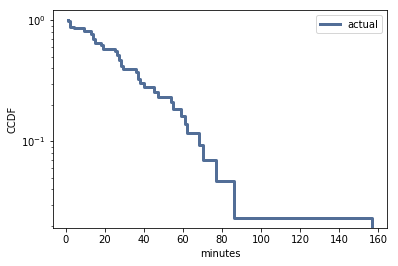

<Figure size 576x432 with 0 Axes>

In [5]:
thinkplot.Cdf(cdf, complement=True)
thinkplot.Show(xlabel='minutes', ylabel='CCDF', yscale='log')

指定参数`complement=True`后，`thinkplot.Cdf`会在绘制图形之前计算CDF补函数。指定参数`yscale='log'`后，`thinkplot.Show`会将`y`轴设置为对数值。

图中的线不是很直，说明指数分布并不是这组数据的完美模型。之前的假设，即婴儿在一天中的任何时间出生的可能性相同，很可能并不成立。尽管如此，使用指数分布对这个数据集进行建模有可能是合理的。经过这种简化，我们用一个参数就可以概括这个分布。

参数$\lambda$可以解释为一个比率，即事件在一个时间单元内发生的平均次数。24小时内出生了44个婴儿，因此这个比率为$\lambda$等于每分钟$0.0306$个婴儿出生。指数分布的均值为$\frac{1}{\lambda}$，故婴儿出生时间的时间间隔均值为32.7分钟。

## 5.2 正态分布
`正态分布`（normal distribution）也称为`高斯分布`，因其能近似描述很多现象而得到广泛使用。实际上，正态分布无处不在是有原因的，我们将在`14.4`节进行讨论。

正态分布由两个参数决定：均值$\mu$和标准差$\sigma$。 $\mu = 0$且$\sigma = 1$的正态分布称为`标准正态分布`（standard normal distribution）。标准正态分布的CDF是用积分定义的，没有封闭解，但有些算法可以进行有效的估算。`SciPy`就提供了一种这样的算法：`scipy.stats.norm`是一个表示正态分布的对象，提供方法cdf，计算标准正态的CDF。

In [6]:
import scipy.stats
scipy.stats.norm.cdf(0)

0.5

这个结果是正确的。标准正态分布的中位数是0（与均值相同），分布中一半的值小于中位数，因此$\rm CDF(0)$为0.5。

`norm.cdf`的可选参数`loc`可以指定均值，`scale`可以指定标准差。

`thinkstats2`的`EvalNormalCdf`函数，参数为mu和sigma，计算$x$的CDF。

In [7]:
def EvalNormalCdf(x, mu=0, sigma=1):
    return scipy.stats.norm.cdf(x, loc=mu, scale=sigma)

EvalNormalCdf(0)

0.5

下展示了一组具有不同参数的正态分布的CDF。这些曲线表现出的$S$形就是正态分布的显著特征：

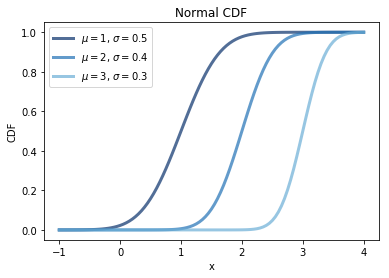

<Figure size 576x432 with 0 Axes>

In [8]:
def MakeNormalCdf():
    """Generates a plot of the normal CDF."""
    
    thinkplot.PrePlot(3)

    mus = [1.0, 2.0, 3.0]
    sigmas = [0.5, 0.4, 0.3]
    for mu, sigma in zip(mus, sigmas):
        xs, ps = thinkstats2.RenderNormalCdf(mu=mu, sigma=sigma,  low=-1.0, high=4.0)
        label = r'$\mu=%g$, $\sigma=%g$' % (mu, sigma)
        thinkplot.Plot(xs, ps, label=label)

    thinkplot.Show(root='analytic_normal_cdf', title='Normal CDF', xlabel='x', ylabel='CDF', loc=2)
    
MakeNormalCdf()

前一章我们研究了全国家庭增长调查中新生儿体重的分布。下图展示了所有成功生产的新生儿体重的经验CDF，以及具有相同均值和方差的正态分布的CDF：

Mean, Var 7.280883100022579 1.5452125703544897
Sigma 1.2430657948614343


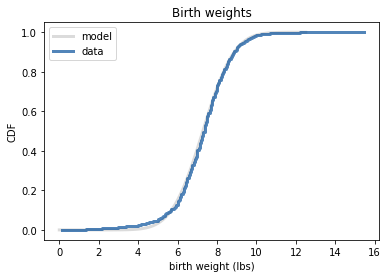

<Figure size 576x432 with 0 Axes>

In [9]:
def MakeNormalModel(weights):
    """Plot the CDF of birthweights with a normal model."""
    
    # estimate parameters: trimming outliers yields a better fit
    mu, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
    print('Mean, Var', mu, var)
    
    # plot the model
    sigma = math.sqrt(var)
    print('Sigma', sigma)
    xs, ps = thinkstats2.RenderNormalCdf(mu, sigma, low=0, high=12.5)

    thinkplot.Plot(xs, ps, label='model', color='0.8')

    # plot the data
    cdf = thinkstats2.Cdf(weights, label='data')

    thinkplot.PrePlot(1)
    thinkplot.Cdf(cdf) 
    thinkplot.Show(root='analytic_birthwgt_model', title='Birth weights', xlabel='birth weight (lbs)', ylabel='CDF')
    
MakeNormalModel(weights)

使用正态分布作为这个数据集的模型非常合适，因此如果我们用参数$\mu = 7.28$和$\sigma = 1.24$概括描述这个分布，结果误差（模型和数据之间的差）将会很小。

在低于第10百分位数的部分，数据和模型之间存在差距。相比正态分布中的期望值，实际数据中体重较轻的新生儿更多。如果我们要专门研究早产儿，就必须把这部分分布描述正确，因此使用正态模型未必合适。

## 5.3 正态概率图
对于指数分布和一些其他分析分布，我们可以通过简单转换来验证一个分析分布模型是否适用于一个数据集。

对于正态分布，则不存在这样的转换，但我们可以使用另外一种方法：正态概率图（normal probability plot）。有两种方法可生成正态概率图：困难方法和简单方法。困难方法[参考](https://en.wikipedia.org/wiki/Normal_probability_plot)。简单方法如下：
1. 将样本中的值排序
2. 从一个标准正态分布($\mu=0, \sigma=1$)，生成一个随机样本并排序，样本大小与需要建模的样本一样
3. 绘制样本的排序值和随机值

如果样本的分布接近正态分布，那么绘制结果将为一条直线，截距为$\mu$，斜率为$\sigma$。`thinkstat2`提供一个方法`NormalProbability`，参数为一个样本，返回两个NumPy数组：

```python
def NormalProbability(ys):
    n = len(ys)
    xs = np.random.normal(0, 1, n)
    xs.sort()
  
    ys = np.array(ys)
    ys.sort()
    return xs, ys

xs, ys = thinkstats2.NormalProbability(sample)
```

`ys`包含`sample`对象中排序后的值，`xs`包含从标准正态分布得到的随机值。

为了测试`NormalProbability`，要生成一些伪样本，这些样本实际上抽取自具有不同参数的正态分布。下图展示了结果。图中的线近似直线，尾部的值偏离程度较高。

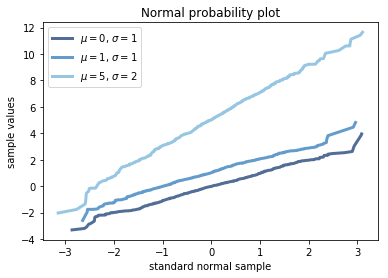

<Figure size 576x432 with 0 Axes>

In [10]:
def MakeExampleNormalPlot():
    n = 1000
    thinkplot.PrePlot(3) 

    mus = [0, 1, 5]
    sigmas = [1, 1, 2]
    for mu, sigma in zip(mus, sigmas):
        sample = np.random.normal(mu, sigma, n)
        xs, ys = thinkstats2.NormalProbability(sample)
        label = '$\mu=%d$, $\sigma=%d$' % (mu, sigma)
        thinkplot.Plot(xs, ys, label=label)

    thinkplot.Show(root='analytic_normal_prob_example',
                   title='Normal probability plot',
                   xlabel='standard normal sample',
                   ylabel='sample values')

MakeExampleNormalPlot()

我们用前一节中的新生儿数据生成正态概率图，其中灰色的线表示模型，蓝色的线表示真实数据：

Mean, Var 7.280883100022579 1.5452125703544897


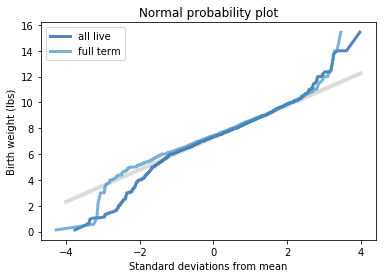

<Figure size 576x432 with 0 Axes>

In [11]:
def MakeNormalPlot(weights, term_weights):
    """Generates a normal probability plot of birth weights."""

    mean, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
    std = math.sqrt(var)
    print('Mean, Var', mean, var)

    xs = [-4, 4]
    # 生成一条直线，以均值为截距、标准差为斜率
    fxs, fys = thinkstats2.FitLine(xs, mean, std)
    thinkplot.Plot(fxs, fys, linewidth=4, color='0.8')

    thinkplot.PrePlot(2) 
    xs, ys = thinkstats2.NormalProbability(weights)
    thinkplot.Plot(xs, ys, label='all live')

    xs, ys = thinkstats2.NormalProbability(term_weights)
    thinkplot.Plot(xs, ys, label='full term')
    thinkplot.Show(root='analytic_birthwgt_normal',
                   title='Normal probability plot',
                   xlabel='Standard deviations from mean',
                   ylabel='Birth weight (lbs)')

MakeNormalPlot(weights, term_weights)

`weights`是一个pandas Series对象，代表新生儿体重。`mean`和`std`分别表示均值和标准差。

`FitLine`方法的参数为`xs`、截距和斜率，返回值为`xs`和`ys`，代表参数既定的直线在`xs`中所取的值。

`NormalProbability`返回`xs`和`ys`，包含了标准正态分布的值以及`weights`中的值。如果`weights`符合正态分布，那么数据应该与模型相符。

上展示了所有成功生产及足月生产的新生儿体重的正态概率图。两条曲线都在靠近均值的部分与模型相符，尾部出现偏差。最重的新生儿比模型预期的更重，最轻的新生儿则比模型预期的更轻。

如果我们只选择足月生产的数据，那么可以去除一部分最轻的体重，减少分布中左尾的偏差。

这张图说明，在距均值几个标准差的范围内，正态模型可以很好地描述样本数据的分布，但尾部偏差较大。至于这个模型能否满足实际需求，就要看具体需求究竟是什么了。

## 5.4 对数正态分布
如果一组值的对数符合正态分布，那么这组值就符合`对数正态分布`（lognormal distribution）。`对数正态分布`的CDF和`正态分布`的CDF一样，只不过将公式中的$x$替换为了$\log{x}$：
+ $\rm CDF_{lognormal}(x) = \rm CDF_{normal}(\log{x})$

对数正态分布的参数通常写为$\mu$和$\sigma$。但是这两个参数并不是均值和标准差。对数正态分布的均值为：
+ $\displaystyle e^{( μ + \frac{σ^2}{2})}$

标准差的公式比较复杂，请[参考](http://wikipedia.org/wiki/Log-normal_distribution)。

如果一个样本近似对数正态分布，那么以$\log{x}$为纵轴绘制其CDF，得到的图形会具备正态分布的特征。要测试样本与对数正态模型的拟合度，可以使用样本中值的$log$值绘制一个正态概率图。

举个例子，让我们来看看成年人的体重分布，这个分布大致符合对数正态分布。2008年，国家慢性病预防和健康促进中心(BRFSS)调查了414509名受访者，收集的数据中包括398484名调查参与者的体重（单位为千克）。

数据文件`CDBRFS08.ASC.gz`是一个等宽列的ASCII码文件，`brfss.py`能够读取数据文件并进行分析。

下面四张图中，左上展示了使用线性刻度的成年人体重的分布和正态模型，右上使用对数刻度展示了同样的分布和对数正态模型。对数正态模型更符合成年人体重分布，但两种模型在拟合度上的差别并不明显：

In [12]:
import brfss

df = brfss.ReadBrfss("datasets/CDBRFS08.ASC.gz")

n, mean, std 398484 78.59599565702814 17.754555191798524
n, mean, std 398484 1.884660713731975 0.0962358025915141


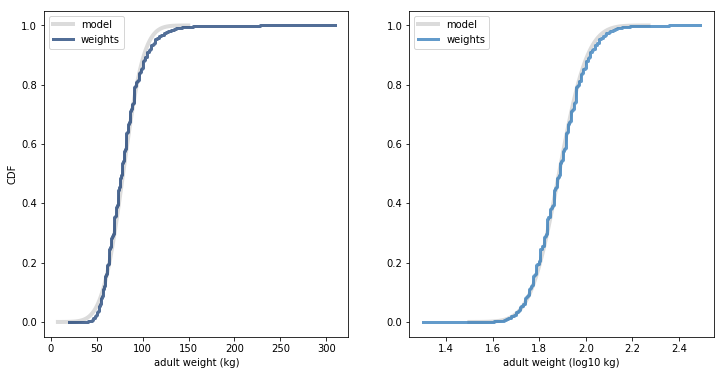

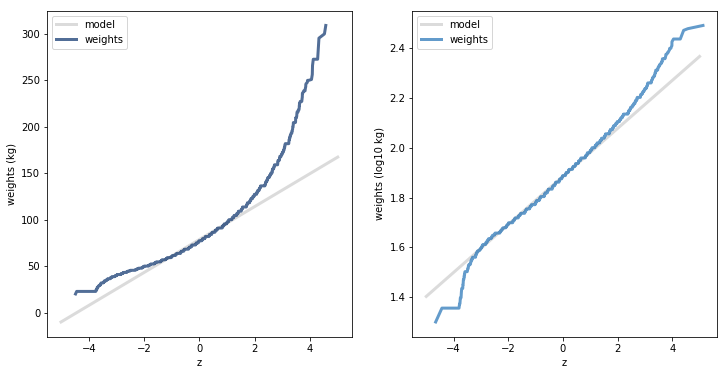

<Figure size 576x432 with 0 Axes>

In [13]:
brfss.MakeFigures(df)

左下和右下两张图展示了成年人体重$w$及其对数$\log_{10}w$的正态概率图。在左下图中，我们看到数据很明显地偏离了正态模型。右下图中，在均值的几个标准差范围内，对数正态分布与数据吻合较好，但是在尾部也出现了偏离。我认为对数正态分布模型很好地模拟了成年人的体重数据。

## 5.5 Pareto分布
`Pareto分布`（Pareto distribution）是以经济学家Vilfredo Pareto的名字命名的。Pareto最初使用这个模型描述财富分布（[参见](http://wikipedia.org/wiki/Pareto_distribution)），之后人们用这个模型描述各种自然和社会科学现象，如城镇人口规模、沙粒和流星、森林火灾和地震。

Pareto分布的CDF为：
+ $\displaystyle \rm CDF(x) = 1-(\frac{x}{x_m})^{-\alpha}$

参数$x_m$和$\alpha$决定了分布的位置和形状。$x_m$是分布中可能出现的最小值。下图展示了$x_m = 0.5$，具有不同$\alpha$值的Pareto分布的CDF：

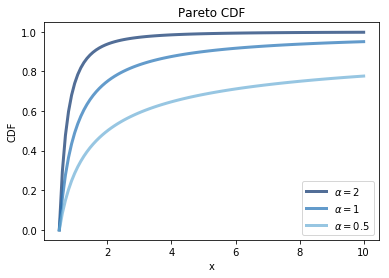

<Figure size 576x432 with 0 Axes>

In [14]:
def MakeParetoCdf():
    """Generates a plot of the Pareto CDF."""
    xmin = 0.5

    thinkplot.PrePlot(3)
    for alpha in [2.0, 1.0, 0.5]:
        xs, ps = thinkstats2.RenderParetoCdf(xmin, alpha, 0, 10.0, n=100) 
        thinkplot.Plot(xs, ps, label=r'$\alpha=%g$' % alpha)
    
    thinkplot.Show(root='analytic_pareto_cdf',
                   title='Pareto CDF',
                   xlabel='x',
                   ylabel='CDF')

MakeParetoCdf()

有一种通过肉眼判断就能检验一个经验分布是否符合Pareto分布的简单方法 ，即如果横轴和纵轴都使用对数刻度，那么CCDF看起来会是一条直线。让我们看看其中的原理。

对于符合Pareto分布的一个样本，如果使用线性刻度绘制其CCDF，那么预期会看到的函数如下：
+ $\displaystyle y\approx(\frac{x}{x_m})^{-\alpha}$

公式两边取对数：
+ $\displaystyle \log y\approx-\alpha(\log{x}-\log{x_m})$

以$\log{x}$为横轴，$\log{y}$为纵轴，那么得到的函数图形会近似一条直线，斜率为$-\alpha$，截距为$\alpha \log{x_m}$。

美国统计局（U.S. Census Bureau）发布美国每个城镇的人口数的数据集`PEP_2012_PEPANNRES_with_ann.csv`。代码库中还有一个`population.py`文件，负责读取数据文件，并绘制人口分布图。

下图展示了横轴和纵轴都使用对数刻度的的人口CCDF。图中人口最多的1%城镇，即小于$10^{-2}$的部分，基本是一条直线。因此，我们可以得出和其他一些研究者相同的结论，即城镇人口分布的尾部符合Pareto模型：

In [15]:
def ReadData(filename='datasets/PEP_2012_PEPANNRES_with_ann.csv'):
    df = pandas.read_csv(filename, header=None, skiprows=2, encoding='iso-8859-1')
    populations = df[7]
    populations.replace(0, np.nan, inplace=True)
    return populations.dropna()

pops = ReadData()
('Number of cities/towns: ', len(pops))

('Number of cities/towns: ', 19515)

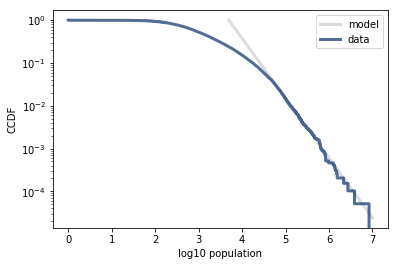

<Figure size 576x432 with 0 Axes>

In [16]:
log_pops = np.log10(pops)
cdf = thinkstats2.Cdf(pops, label='data')
cdf_log = thinkstats2.Cdf(log_pops, label='data')

# pareto plot
xs, ys = thinkstats2.RenderParetoCdf(xmin=5000, alpha=1.4, low=0, high=1e7)
thinkplot.Plot(np.log10(xs), 1-ys, label='model', color='0.8')

thinkplot.Cdf(cdf_log, complement=True) 
thinkplot.Config(xlabel='log10 population', ylabel='CCDF', yscale='log')
thinkplot.Show(root='populations_pareto')

对数正态分布也可以很好地模拟城镇人口数据。左图展示了城镇人口规模的CDF和对数正态模型，右图是正态概率图。两个图中的数据和模型都相当吻合：

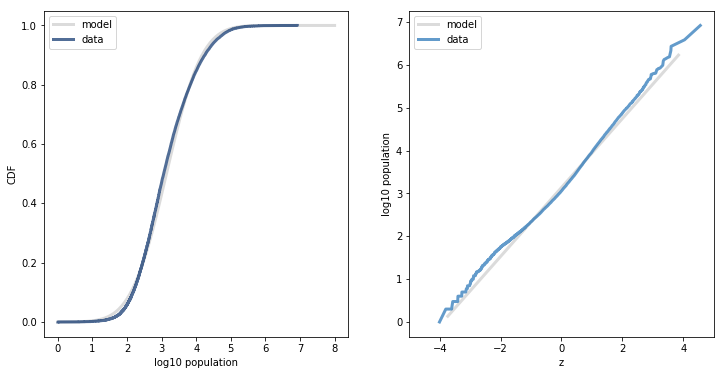

<Figure size 576x432 with 0 Axes>

In [17]:
thinkplot.PrePlot(cols=2)

mu, sigma = log_pops.mean(), log_pops.std()
xs, ps = thinkstats2.RenderNormalCdf(mu, sigma, low=0, high=8)
thinkplot.Plot(xs, ps, label='model', color='0.8')

thinkplot.Cdf(cdf_log) 
thinkplot.Config(xlabel='log10 population', ylabel='CDF')

thinkplot.SubPlot(2)
thinkstats2.NormalProbabilityPlot(log_pops, label='data')
thinkplot.Config(xlabel='z', ylabel='log10 population', xlim=[-5, 5])

thinkplot.Show(root='populations_normal')

这两个模型都不完美。Pareto模型只适合人口规模最多的1%的城镇，但在这部分的拟合度更高。对数正态模型对其他99%的城镇拟合度更高。使用哪个模型更合适，取决于我们关注的是分布的哪一部分。

## 5.6 随机数生成
我们可以使用分析CDF，根据给定的分布函数$p = \rm CDF(x)$，生成随机数。如果我们有计算CDF反函数的有效方法，就可以从0到1的均匀分布中选择$p$，然后得到$x = \rm{ICDF}(p)$，从而为适当的分布生成随机数。

例如，指数分布的CDF为：
+ $p = 1 - e^{-λx}$

求解$x$的公式为：
+ $\displaystyle x = -\frac{\log{(1-p)}}{λ}$

Python代码：

In [18]:
def expovariate(lam):
    p = random.random()
    x = -math.log(1-p) / lam
    return x

函数`expovariate`的参数为`lam`，返回使用`lam`从指数分布中选取的一个随机数。另外，因为$\log{0}$没有定义，所以我们必须小心处理。`random.random`返回值可以为0，但不会为1，因此$1-p$可能为1，但不会为0，$\log{(1-p)}$不会出现没有定义的情况。

## 5.7 为什么使用模型
现实世界的很多现象都可以用分析分布进行建模。

和所有模型一样，分析分布也是一种抽象，忽略了无关的细节。例如，一个观测分布可能带有测量误差或这个样本的独有特征，分析模型将这些特殊性都消除了。

分析模型也是一种数据压缩形式。如果模型很好地拟合了一个数据集，那么我们只需几个参数便可对大量的数据进行概括。

有时候，我们会惊讶地发现一种自然现象符合某个分析分布，而这些观察可以帮助人们更好地了解物理系统。有时我们可以对一个观测分布为何具有某种形态作出解释。例如，Pareto分布经常是由带有正反馈的生成性过程（所谓的偏好依附过程，请[参考](http://wikipedia.org/wiki/Preferential_attachment)）导致的。

而且，分析分布很容易进行数学分析。`第14章`将会对此进行讨论。

但是，我们必须记住：所有模型都是不完美的。现实世界的数据永远不会完美地符合一个分析分布。

如果模型描述了真实世界的相关特征，省略了不必要的细节，那么模型就是有用的。但是，什么是`相关`的，什么是`不必要`的，这取决于你将这个模型用于何种用途。